In [1]:
import numpy as np
import pandas as pd
from functions import *
from schemes import *
from plot import * 
from Kepler import *
from adaptive import *
from FRSolver import *

%matplotlib inline

#### FIG 8

In [2]:
# gravity
G = 1

m1 = 1 
m2 = 1 
m3 = 1

# position
r1 = np.array([0,0.0,0.0], dtype="float64")
r2 = np.array([1,0.0,0.0], dtype="float64")
r3 = np.array([-1,0.0,0.0], dtype="float64")

p1 = 0.347111
p2 = 0.532728

# velocity 
v1 = np.array([-2 * p1,-2*p2,0], dtype="float64")
v2 = np.array([p1,p2,0], dtype="float64")
v3 = np.array([p1,p2,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

In [3]:
T = 100
C = 0.55

In [4]:
traj, stabilities = fullSolver(T, C, r0s, v0s, G, masses)

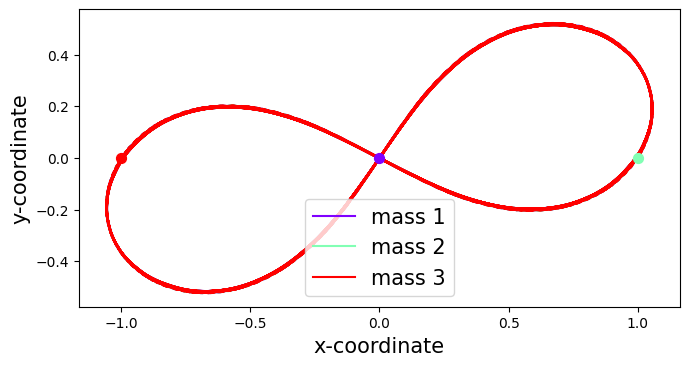

In [5]:
PlotOrbits(traj)

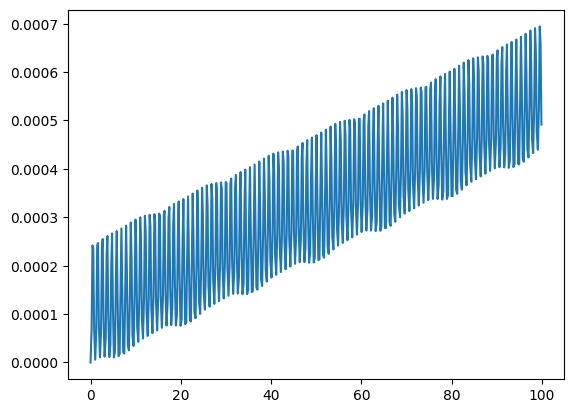

In [6]:
plt.plot(traj[0], traj[3])

In [7]:
hvals = np.diff(traj[0])

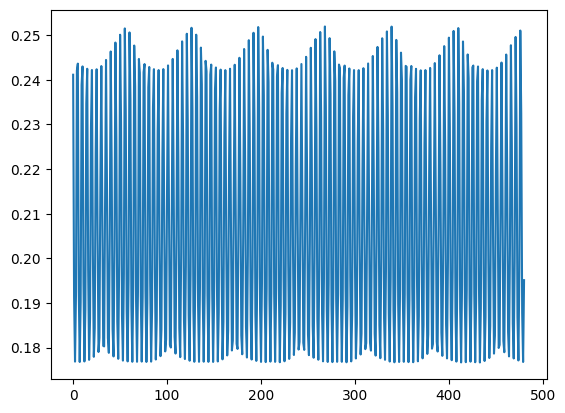

In [8]:
plt.plot(hvals)

In [9]:
def distCalculator(rs):
    N = len(rs)
    Rs = []
    for i in range(N):
        for j in range(i + 1, N):
            Rs.append


#### EULER

In [10]:
# gravity
G = 1

m1 = 1
m2 = 1
m3 = 1

# position
r1 = np.array([-1,0.0,0.0], dtype="float64")
r2 = np.array([0,0.0,0.0], dtype="float64")
r3 = np.array([1,0.0,0.0], dtype="float64")
 
w = np.sqrt(1.25)
# velocity 
v1 = w* np.array([0,-1,0], dtype="float64")
v2 = w* np.array([0,0,0], dtype="float64")
v3 = w* np.array([0,1,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

In [11]:
traj, stability = fullSolver(100, 0.25, r0s, v0s, G, masses)

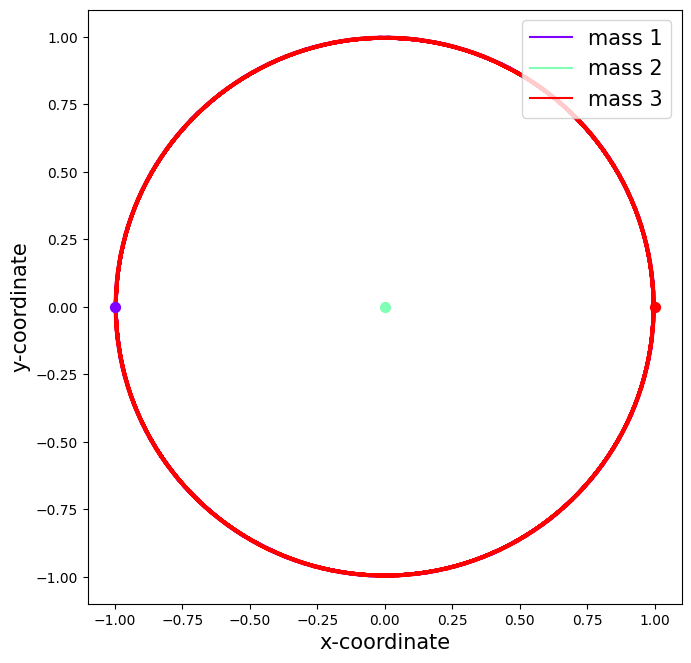

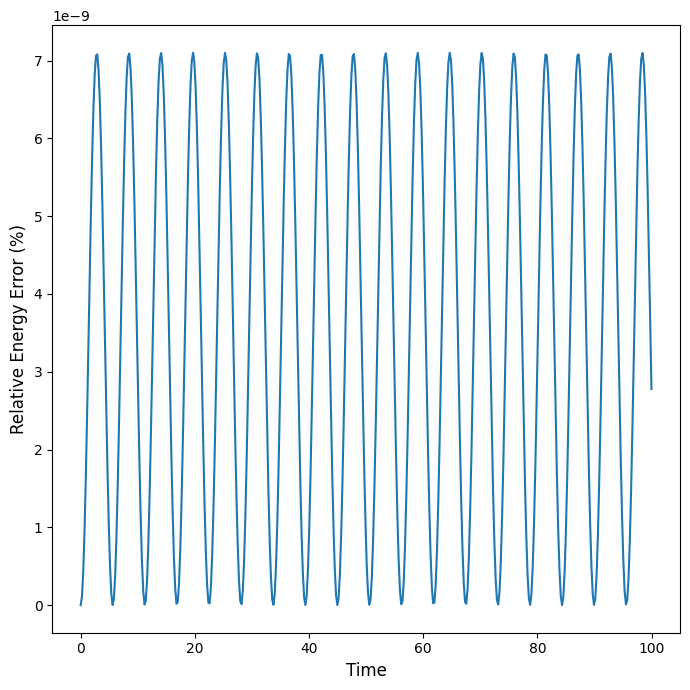

In [12]:
PlotOrbits(traj)
PlotTotalEnergy(traj)

#### LAGRANGE

In [13]:
# gravity
G = 1

m1 = 1
m2 = 1
m3 = 1

w = 0.75984

# position
r1 = np.array([0,1,0], dtype="float64")
r2 = np.array([- np.cos(np.pi / 6), - np.sin(np.pi / 6),0.0], dtype="float64")
r3 = np.array([np.cos(np.pi / 6), - np.sin(np.pi / 6),0.0], dtype="float64")

# velocity 
v1 = w * np.array([-1, 0, 0], dtype="float64")
v2 = w * np.array([np.sin(np.pi / 6),-np.cos(np.pi / 6),0], dtype="float64")
v3 = w* np.array([np.sin(np.pi / 6),np.cos(np.pi / 6),0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

In [41]:
traj, stability = fullSolver(60, 0.2, r0s, v0s, G, masses)
print(stability)

1


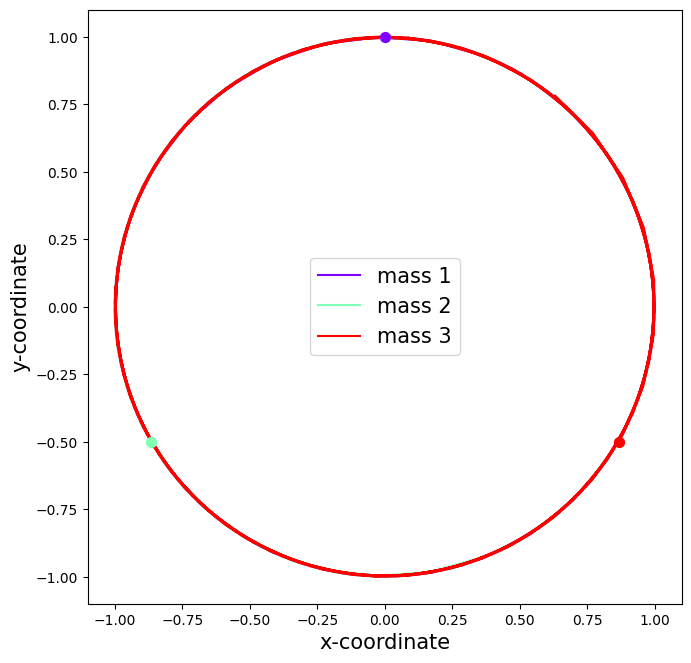

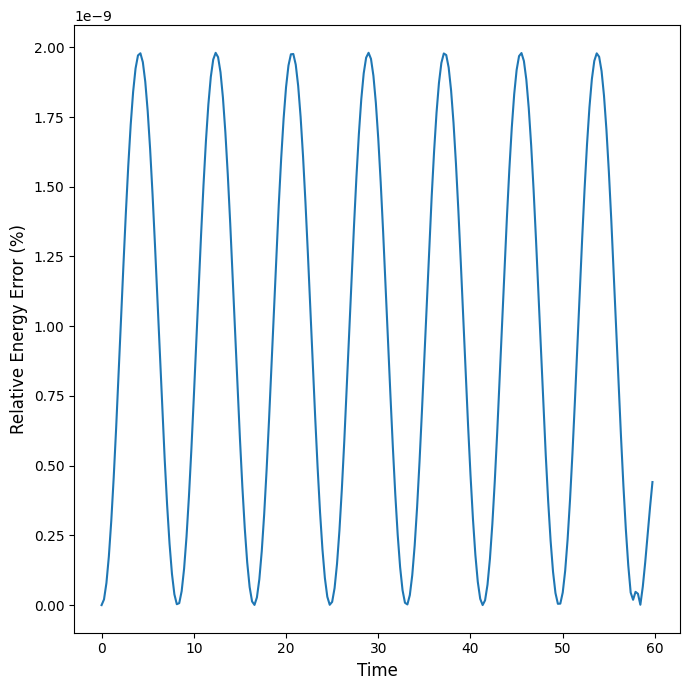

In [42]:
PlotOrbits(traj)
PlotTotalEnergy(traj)